# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Defining-the-hypoxia-response" data-toc-modified-id="Defining-the-hypoxia-response-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Defining the hypoxia response</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-Global-HIF-1-response" data-toc-modified-id="Enrichment-Analysis-of-the-Global-HIF-1-response-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Enrichment Analysis of the Global HIF-1 response</a></div>

In this notebook, we will isolate the hypoxia response (defined as the set of genes that fulfill the genetic equalities *egl-9 = egl9;vhl-1* and *hif-1 = egl-9 hif-1*), and we will perform enrichment analysis on the hypoxia response. We will also perform enrichment analyses on each mutant transcriptomes, to try to understand how different each transcriptome actually is.

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan
import gvars
import epistasis as epi

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif',
              'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png','retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
q = 0.1
# this loads all the labels we need
genvar = gvars.genvars()

tissue_df = tea.fetch_dictionary()
phenotype_df = tea.fetch_dictionary('phenotype')
go_df = tea.fetch_dictionary('go')
respiratory_complexes = pd.read_excel('../input/respiratory_complexes.xlsx')

In [3]:
tidy = pd.read_csv('../output/temp_files/DE_genes.csv')
tidy.sort_values('target_id', inplace=True)
tidy.dropna(subset=['ens_gene'], inplace=True)

# Defining the hypoxia response


The hypoxia response can be defined in genetic terms as those genes that obey the two epistasis relationships, *egl-9 = egl-9;vhl-1* and *hif-1 = egl-9 hif-1*.

In [4]:
def test_equality(equal_genotypes, third_genotype, df, col='code', q=0.1, n_std=2):
    """
    A function to test epistasis equality.
    
    For a set of genotypes, `a`, `b`, and `ab`, suppose that we want to find those
    genes that obey the rule `a`=`ab`. To identify genes with this expression
    pattern, we first calculate the epistasis coefficient for transcripts within
    the STP(`a`, `ab`). Then, we find those transcripts that are <2sigma
    deviations away from the line of best fit.
    
    Params:
    equal_genotypes: the two genotypes that we want to set equal to each other
    third_genotype: the third genotype to be considered (needed to calculate
    epistasis coeff.).
    df - dataframe to use. Must contain `target_id` column
    col - column that encodes the genotypes
    q - q-value to be used
    n_std - number of standard deviations to use as cutoff
    
    Output:
    A list of target_ids
    """
    a, ac = equal_genotypes
    c = third_genotype
    
    # make sure the dataframe only contains the desired genotypes
    all_genotypes = [a, ac, c]
    
    df = df[df[col].isin(all_genotypes)]
    
    overlap = epi.find_overlap(equal_genotypes, df, col=col, q=q)
    
    df = df[df.target_id.isin(overlap)]
    a_df = df[df[col] == a].copy()
    c_df = df[df[col] == c]
    ac_df = df[df[col] == ac]
        
    # the code below works only if the variance is invariant to expected value
    normed_deltas = (ac_df.b.values - a_df.b.values)
    normed_deltas = normed_deltas/np.std(normed_deltas)
    
    # first condition guarantees we're not too far from the line y=x
    # second condition guarantees we are not on the line y=-x
    inside = (np.abs(normed_deltas) < n_std) & (ac_df.b.values*a_df.b.values > 0)
    
    # print a diagnostic plot:
    plt.scatter(a_df[inside].b, ac_df[inside].b, s=1/ac_df[inside].se_b,
                color='black', alpha=.2, label='selected')
    plt.scatter(a_df[~inside].b, ac_df[~inside].b, s=1/ac_df[~inside].se_b,
                color='red', alpha=1, label='outlier')
    plt.xlabel('a')
    plt.ylabel('ac')
    plt.legend()

    # return list of target ids that meet criteria
    return a_df[inside].target_id.values
    

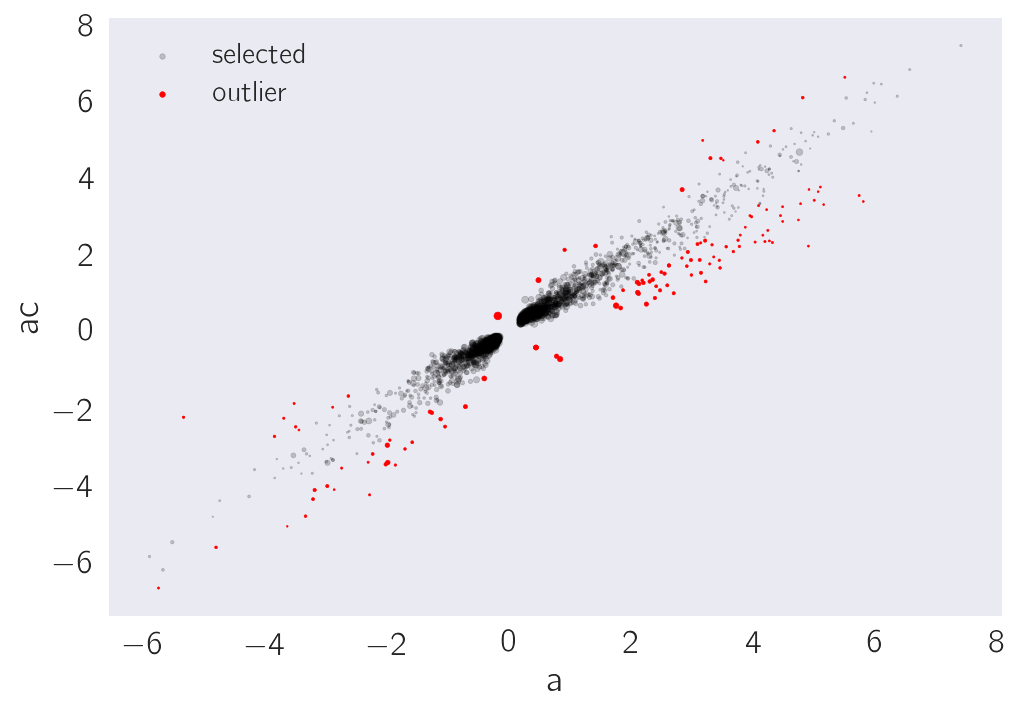

In [5]:
# find the genes that obey egl-9 = egl-9;vhl-1
filtered_egl = test_equality(['b', 'a'], 'd', tidy, n_std=2)

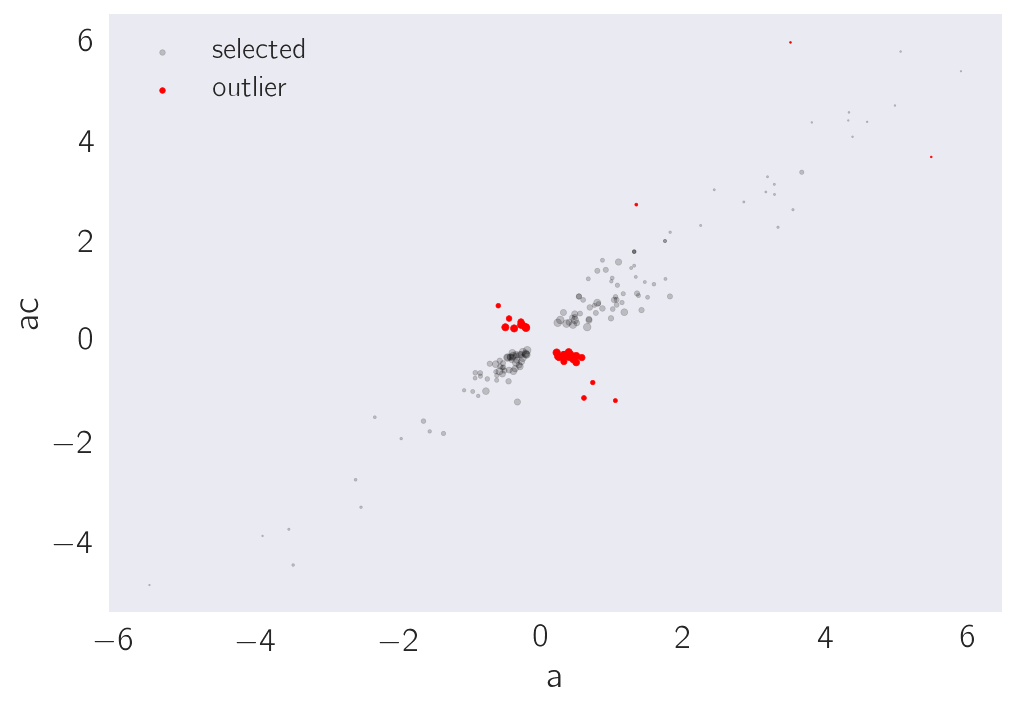

In [6]:
# find the genes that obey hif-1 = egl-9 hif-1
filtered_hif = test_equality(['c', 'f'], 'b', tidy, q=.1, n_std=2)

In [7]:
# find those genes that are not DE in either hif-1 or egl-9 hif-1
not_DE_hif = (tidy.code.isin(['c', 'f'])) & (tidy.qval > q)
# a neat trick:
not_DE = epi.find_overlap(['c', 'f'], tidy[not_DE_hif], q=1)

In [8]:
# genes DE in hif-1 and egl-9, and obey both equations:
equal_and_DE = ((tidy.target_id.isin(filtered_egl)) &
                (tidy.target_id.isin(filtered_hif)))
# genes that are DE in egl-9, but not in hif-1 genotypes
# and also obey both equations:
equal_no_hif = ((tidy.target_id.isin(filtered_egl)) &
                (tidy.target_id.isin(not_DE)))

# get the lists of both, then concatenate them for a
# hypoxia response: most of the genes will come from
# the equal_no_hif condition
de_both = tidy[(equal_and_DE)].target_id.unique()
de_one = tidy[(equal_no_hif)].target_id.unique()
overlap = list(set(np.append(de_both, de_one)))

# find the hypoxia response
hyp_response = tidy[tidy.target_id.isin(overlap)].copy()

In [9]:
# annotate whether they are candidates for direct or
# indirect regulation.
def annotate(x):
    if x > 0:
        return 'candidate for direct regulation'
    else:
        return 'candidate for indirect regulation'

# annotate
hyp_response['regulation'] = hyp_response.b.apply(annotate)

In [10]:
# save to file
cols = ['genotype','target_id', 'ens_gene', 'ext_gene', 'b',
        'se_b', 'qval', 'regulation', 'code']
hyp_response[cols].to_csv('../output/temp_files/hypoxia_response.csv',
                          index=False)

m = 'There are {0} genes in the predicted hypoxia response'
print(m.format(len(hyp_response.ens_gene.unique())))

There are 1258 genes in the predicted hypoxia response


# Enrichment Analysis of the Global HIF-1 response

Now that we have found the hypoxia response, we can perform tissue, phenotype and gene ontology enrichment analysis on this gene battery.
Note that we don't show all possibilities. When a particular analysis is not present, it is because the enrichment results were empty.

In [11]:
teaH = tea.enrichment_analysis(hyp_response.ens_gene.unique(),
                               tissue_df, show=False)
peaH = tea.enrichment_analysis(hyp_response.ens_gene.unique(),
                               phenotype_df, show=False)
geaH = tea.enrichment_analysis(hyp_response.ens_gene.unique(),
                               go_df, show=False)

for df in [teaH, peaH, geaH]:
    df['logq'] = -df['Q value'].apply(np.log10)

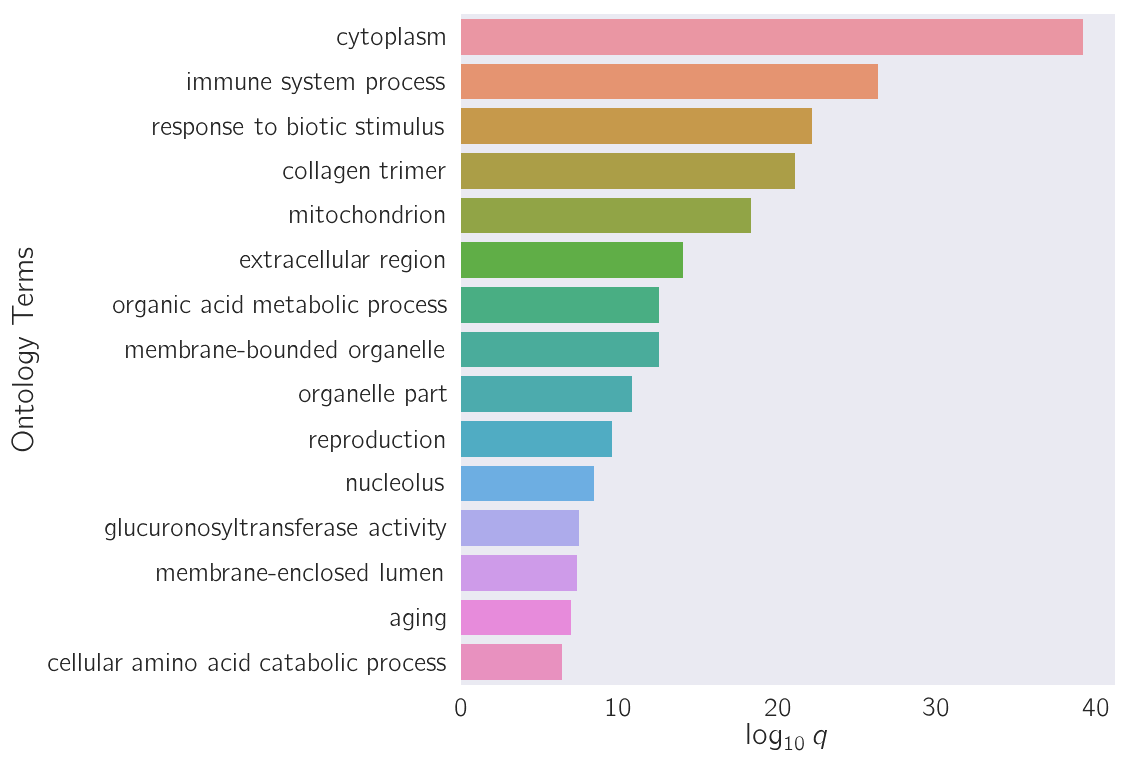

In [12]:
ax = tea.plot_enrichment_results(geaH, analysis='go', y='logq')
plt.xlabel('$\log_{10}{q}$')
plt.savefig('../output/supp_figures/supplementary_figure_3.svg')

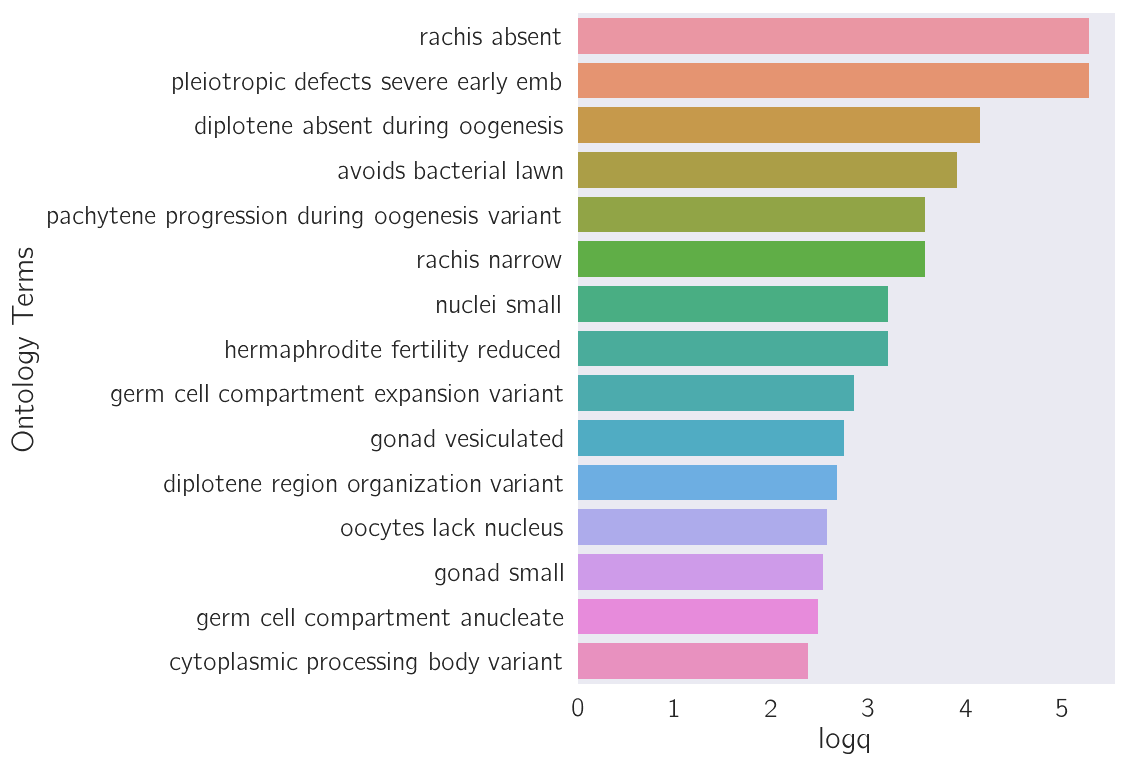

In [13]:
tea.plot_enrichment_results(peaH, analysis='phenotype', y='logq')

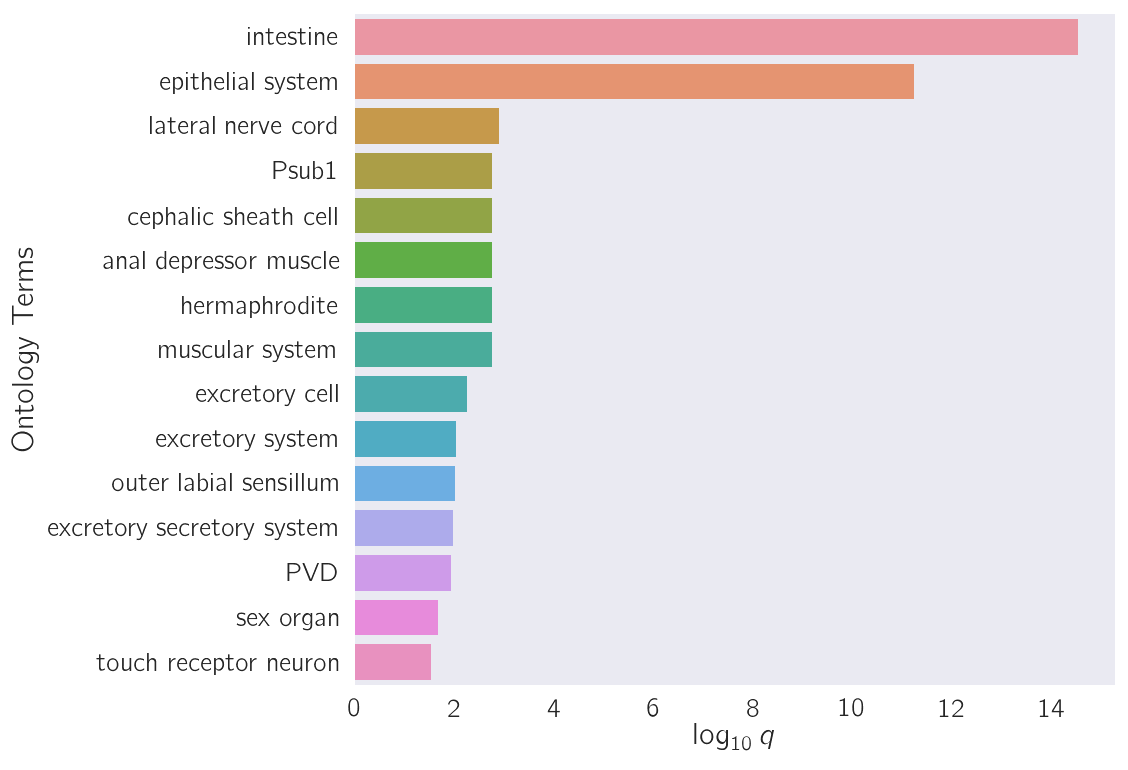

In [14]:
ax = tea.plot_enrichment_results(teaH, analysis='tissue', y='logq')
plt.xlabel('$\log_{10}{q}$')
plt.savefig('../output/supp_figures/supplementary_figure_4.svg', bbox_inches='tight')